# PW04 - Group 4
* Florian Bär
* Matthias Egli
* Manuel Vogel
* Adrian Willi

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

### Loading the Data

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

### Model

In [3]:
# your favourite MLP model

drop_p = 0
complexity = 200
nepochs = 100
lr = 0.25


def get_model():
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Dropout(p=drop_p),
        torch.nn.Linear(784, complexity),
        torch.nn.Dropout(p=drop_p),
        torch.nn.Sigmoid(),
        torch.nn.Linear(complexity, 10)
    )

In [4]:
summary(get_model(), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
           Dropout-4                  [-1, 200]               0
           Sigmoid-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


### Train-Eval over a given number of epochs for a given train/validation loader (4+1 fold)

In [5]:
def train_eval(nepochs, model, lr, trainloader, validloader, cost_fn):
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
    for epoch in range(nepochs):

        training_cost = 0
        correct = 0
        for inputs, targets in trainloader:
            optimizer.zero_grad()
            predictions = model(inputs)
            cost = cost_fn(predictions, targets)
            cost.backward()
            optimizer.step()
            training_cost += cost.item()
            correct += (torch.argmax(predictions, dim=1) == targets).sum()
        
        cost = training_cost / len(trainloader.sampler)
        acc = correct / len(trainloader.sampler)
        
        validation_cost = 0
        correct = 0
        for inputs, targets in validloader:
            predictions = model(inputs)
            cost = cost_fn(predictions, targets)
            validation_cost += cost.item()
            correct += (torch.argmax(predictions, dim=1) == targets).sum()
        
        cost_test = validation_cost / len(validloader.sampler)
        acc_test = correct / len(validloader.sampler)
        
        
        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Split Training Data into folds

Prepare specific loaders for the 4 training folds and the 1 validation fold

Suggestions:
* Use sklearns KFold functionality for spliiting into folds.
* Use pytorchs subsamplers (torch.utils.data.SubsetRandomSampler) to construct training and validation loaders

In [6]:
# Configuration options
nfolds = 5
nepochs = 20
lr = 0.25
batchsize = 64

cost_fn = torch.nn.CrossEntropyLoss()
results = {}

kfold = KFold(n_splits=nfolds, shuffle=True, random_state=42)

In [7]:
for fold, (train_ids, valid_ids) in enumerate(kfold.split(training_data)):

    print(f'FOLD {fold}')
    print('--------------------------------')
    
    model = get_model()
    
    train_sampler = SubsetRandomSampler(train_ids)
    valid_sampler = SubsetRandomSampler(valid_ids)
    
    trainloader = DataLoader(training_data, batch_size=batchsize, sampler=train_sampler)
    validloader = DataLoader(training_data, batch_size=batchsize, sampler=valid_sampler)
    
    results[fold] = train_eval(nepochs, model, lr, trainloader, validloader, cost_fn)

FOLD 0
--------------------------------
Epoch 0: 0.662207, 0.725812, 0.008872, 0.783167
Epoch 1: 0.419610, 0.822062, 0.007167, 0.833833
Epoch 2: 0.262685, 0.839271, 0.006880, 0.842167
Epoch 3: 0.434070, 0.849437, 0.006403, 0.851000
Epoch 4: 0.589038, 0.855229, 0.006203, 0.856750
Epoch 5: 0.332390, 0.861229, 0.006211, 0.854750
Epoch 6: 0.628053, 0.864792, 0.007092, 0.826750
Epoch 7: 0.363833, 0.869062, 0.005836, 0.863583
Epoch 8: 0.409610, 0.872771, 0.005757, 0.866500
Epoch 9: 0.553451, 0.874396, 0.005772, 0.867000
Epoch 10: 0.481720, 0.877271, 0.005817, 0.865917
Epoch 11: 0.239612, 0.879396, 0.005506, 0.871833
Epoch 12: 0.368776, 0.881187, 0.005406, 0.876917
Epoch 13: 0.466165, 0.883417, 0.005361, 0.878083
Epoch 14: 0.253203, 0.886208, 0.005251, 0.877083
Epoch 15: 0.217203, 0.887354, 0.005266, 0.879583
Epoch 16: 0.288899, 0.888667, 0.005273, 0.879000
Epoch 17: 0.522380, 0.891062, 0.005425, 0.874333
Epoch 18: 0.209437, 0.893812, 0.005074, 0.883333
Epoch 19: 0.150267, 0.894271, 0.005263,

### Prepare output plots

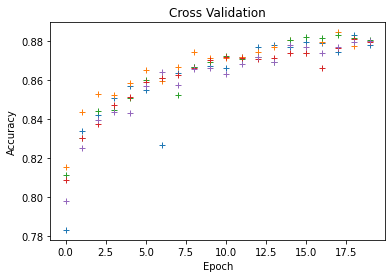

In [8]:
acc_hist_test_idx = 3
plt.figure()
for i in range(nfolds):
    plt.plot(torch.arange(nepochs), results[i][acc_hist_test_idx], "+")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Cross Validation")
plt.show()